In [8]:
import numpy as np
from datasets import load_dataset, DatasetDict
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
import evaluate
import matplotlib.pyplot as plt


In [9]:
def load_data():
    """Load and preprocess the Yelp dataset (binary classification)"""
    dataset = load_dataset("yelp_review_full")

    # Convert to binary: 0 = negative (1-2 stars), 1 = positive (3-5 stars)
    dataset = dataset.map(lambda x: {"label": 1 if x["label"] >= 2 else 0})

    # 80/20 stratified split
    split = dataset["train"].train_test_split(
        test_size=0.2,
        stratify_by_column="label",
        seed=42
    )
    return DatasetDict({
        "train": split["train"],
        "test": dataset["test"]
    })

dataset = load_data()
print(f"Dataset size:\nTrain: {len(dataset['train'])}\nTest: {len(dataset['test'])}")


Dataset size:
Train: 520000
Test: 50000


In [10]:
def init_model():
    """Initialize tokenizer and DistilBERT model"""
    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=2,
        id2label={0: "negative", 1: "positive"},
        label2id={"negative": 0, "positive": 1}
    )
    return tokenizer, model

tokenizer, model = init_model()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def tokenize_data(dataset, tokenizer):
    """Tokenize the text data"""
    return dataset.map(
        lambda x: tokenizer(
            x["text"],
            padding="max_length",
            truncation=True,
            max_length=512
        ),
        batched=True
    )

tokenized = {
    "train": tokenize_data(dataset["train"], tokenizer),
    "test": tokenize_data(dataset["test"], tokenizer)
}


In [13]:
from transformers import TrainingArguments
print(TrainingArguments.__init__.__code__.co_varnames)


('self', 'output_dir', 'overwrite_output_dir', 'do_train', 'do_eval', 'do_predict', 'eval_strategy', 'prediction_loss_only', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'per_gpu_train_batch_size', 'per_gpu_eval_batch_size', 'gradient_accumulation_steps', 'eval_accumulation_steps', 'eval_delay', 'torch_empty_cache_steps', 'learning_rate', 'weight_decay', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'max_grad_norm', 'num_train_epochs', 'max_steps', 'lr_scheduler_type', 'lr_scheduler_kwargs', 'warmup_ratio', 'warmup_steps', 'log_level', 'log_level_replica', 'log_on_each_node', 'logging_dir', 'logging_strategy', 'logging_first_step', 'logging_steps', 'logging_nan_inf_filter', 'save_strategy', 'save_steps', 'save_total_limit', 'save_safetensors', 'save_on_each_node', 'save_only_model', 'restore_callback_states_from_checkpoint', 'no_cuda', 'use_cpu', 'use_mps_device', 'seed', 'data_seed', 'jit_mode_eval', 'use_ipex', 'bf16', 'fp16', 'fp16_opt_level', 'half_precision_backend',

In [14]:
!pip install -U "accelerate>=0.26.0"
!pip show accelerate

Name: accelerate
Version: 1.6.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: C:\python\Lib\site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [27]:
train_size = len(tokenized["train"]) // 100
test_size = len(tokenized["test"]) // 100

train_subset = tokenized["train"].select(range(train_size))
test_subset = tokenized["test"].select(range(test_size))

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch", 
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=42,
    logging_dir="./logs",
    load_best_model_at_end=True,
    eval_steps=None
)


In [28]:
import evaluate
from transformers import Trainer
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=test_subset,
    compute_metrics=compute_metrics
)



In [32]:
print("Training started...")
trainer.train()

results = trainer.evaluate()
print(f"\nFinal test accuracy: {results['eval_accuracy']:.2%}")

trainer.save_model("restaurant_sentiment_model")
print("Model saved to: restaurant_sentiment_model")


Training started...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.391600,0.421702,0.834000
2,0.272400,0.556703,0.852000
3,0.178900,0.619724,0.864000



Final test accuracy: 83.40%
Model saved to: restaurant_sentiment_model


Saved training metrics plot to: training_metrics.png


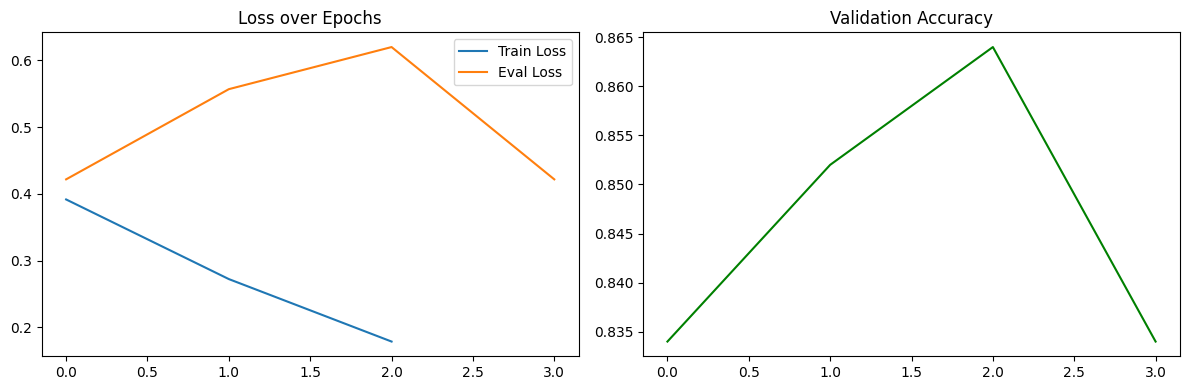

In [33]:
def plot_training_metrics(trainer):
    """Visualize training and evaluation metrics"""
    history = trainer.state.log_history

    train_loss = [x["loss"] for x in history if "loss" in x]
    eval_loss = [x["eval_loss"] for x in history if "eval_loss" in x]
    eval_acc = [x["eval_accuracy"] for x in history if "eval_accuracy" in x]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(eval_loss, label="Eval Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(eval_acc, label="Eval Accuracy", color="green")
    plt.title("Validation Accuracy")

    plt.tight_layout()
    plt.savefig("training_metrics.png")
    print("Saved training metrics plot to: training_metrics.png")

plot_training_metrics(trainer)
